# Checking Linearity of Qubit Dynamics
This notebook shows how to check the linearity of a backend.
In particular, we run a Rabi experiment to find a 𝜋-pulse amplitude on a model of the Armonk one qubit backend.

## Contents
1. Imports
2. Run Rabi experiments
3. fit $\pi$-pulse amplitude <#rabi>

In [1]:
#1. Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit import IBMQ
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit import pulse
from qiskit.pulse import DriveChannel, library
from qiskit.pulse.macros import measure

IBMQ.load_account()
armonk_real = IBMQ.providers()[1].backends.ibmq_armonk

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [ ]:
#2. Run Rabi experiments and fit 𝜋-pulse amplitude
#Next, we run a Rabi experiments generated using Ignis on the Armonk backend.

In [2]:
#First, construct Rabi experiment schedules:
# qubit list
qubit = 0

#Number of shots
num_shots = 2048

# drive shape parameters
drive_duration = np.arange(128, 4096, 128)
drive_sigma = np.arange(16, 512, 16)
# print(drive_sigma)
# print(drive_duration)

# drive amplitudes to use
drive_amps = np.linspace(0.3, 1.0, 13)
# print(drive_amps)

# list of drive channels
drive_channels = [DriveChannel(0)]

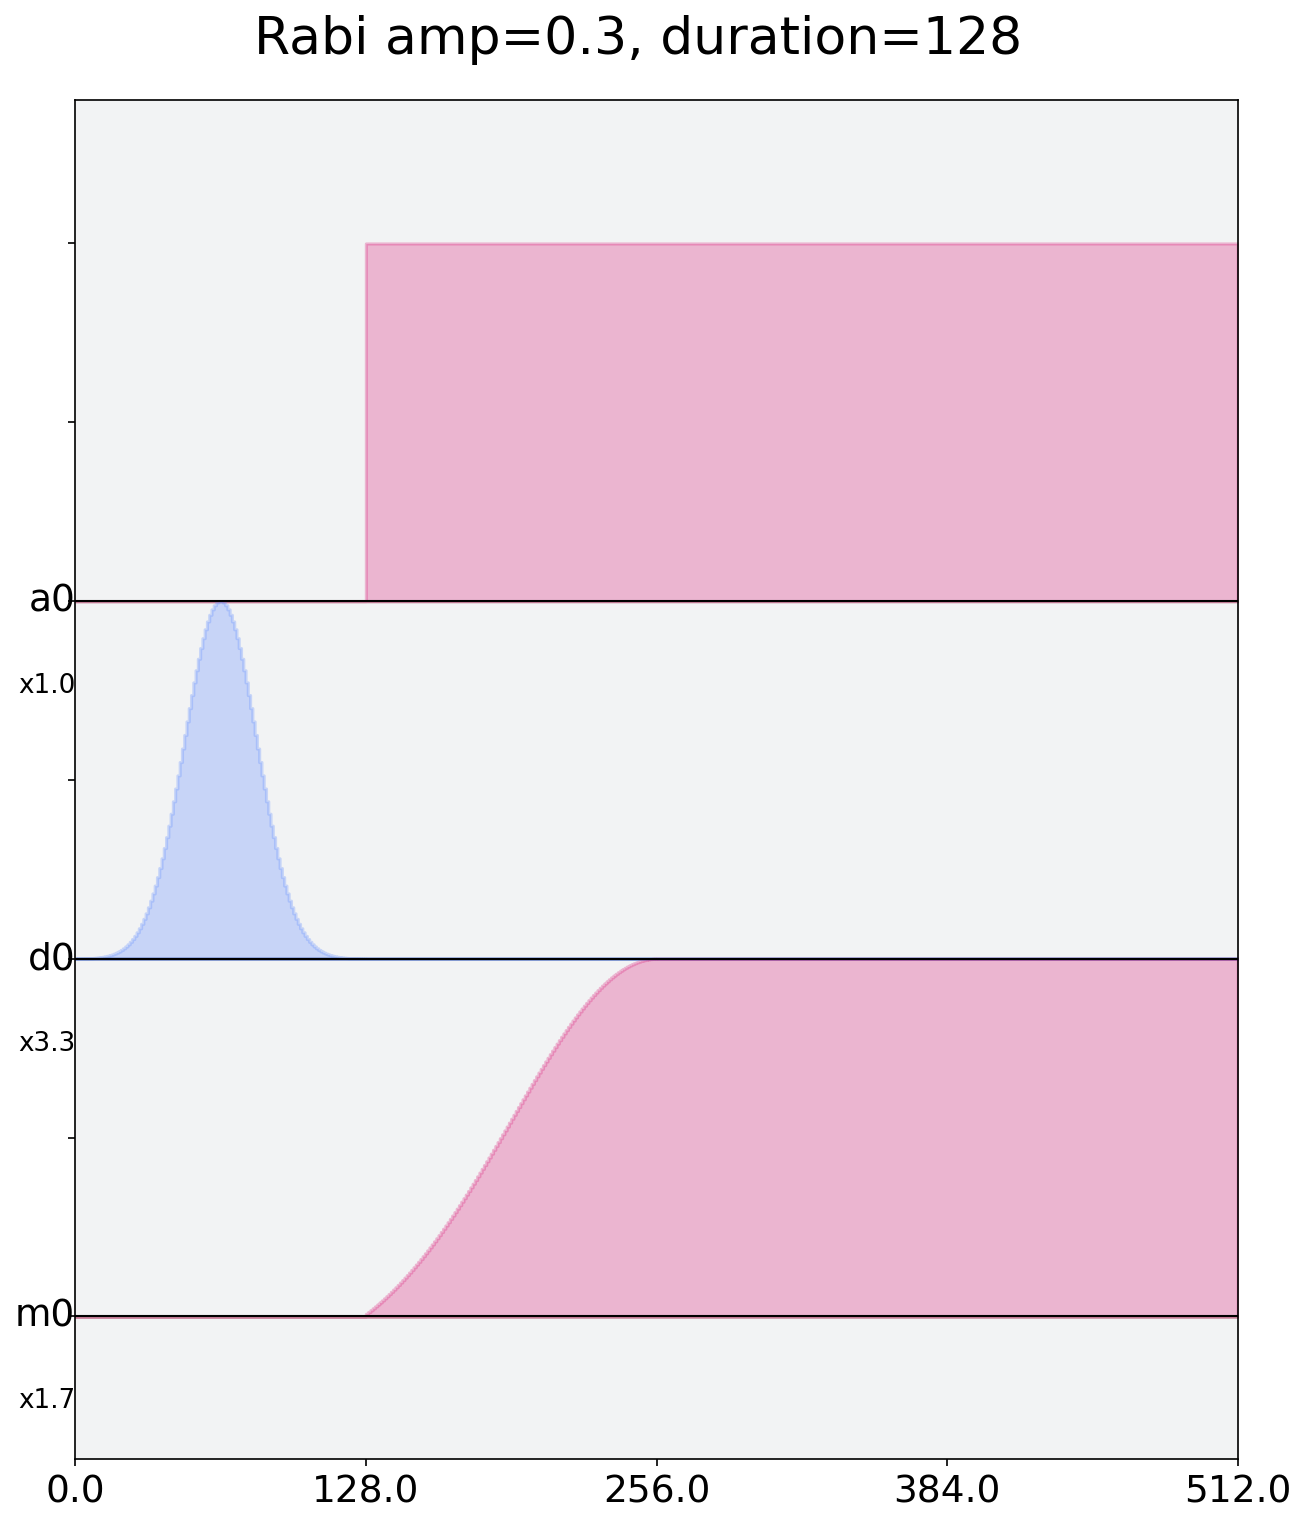

In [3]:
rabi_schedules=[]
for amp in drive_amps:
    for i in range(len(drive_duration)):
        sched = pulse.Schedule(name='Rabi amp={}, duration={}'.format(amp, drive_duration[i]))
        sched += pulse.Play(library.Gaussian(int(drive_duration[i]),amp,int(drive_sigma[i])).get_waveform(),pulse.DriveChannel(qubit))
        sched += measure([qubit], armonk_real) << sched.duration
        rabi_schedules.append(sched)

    #Assemble the qobj for job submission.
    #When assembling pulse schedules to be used with the pulse simulator, pass the PulseSimulator as the backend.
rabi_schedules[0].draw(plot_range=[0,512])

In [4]:
#Run the simulation:
# (Since the number of experiments is too large, we use job_manager to split the experiments automatically)
job_set = IBMQJobManager().run(rabi_schedules,
                               backend=armonk_real,
                               meas_level=1,
                               meas_return='avg',
                               shots=num_shots,
                               job_tags=['Rabi_Linearity'],
                               job_name='Linearity_job_set',
                               job_share_level='global')
print('Job Set ID ', job_set.job_set_id())

set_results = job_set.results()
result = set_results.combine_results()

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


Job Set ID  cb520aa4ebfe4cf88d6910205a874dd5-16013997460231557


In [5]:
cnt_sched = 0
response  = []
for amp in drive_amps:
    resp_Amp = []
    for i in range(len(drive_duration)):
        resp_Amp.append(result.get_memory(cnt_sched)[qubit])
        cnt_sched = cnt_sched + 1
    response.append(resp_Amp)
# print(len(response))

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


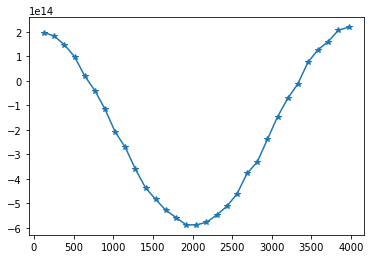

In [6]:
plt.figure(facecolor='w')
plt.plot(drive_duration, response[0],'-*')
plt.show()

In [9]:
def cos_fit_func(x, a, b, w, phi):
    return b + a * np.cos(2*np.pi*x*w + phi)

def fit_freq(x, y, xmax):
    """  [default]   xmax = 2.5

    """
    y2 = 1/np.abs(np.max(y)) * np.real(y)
    x2 = np.linspace(0, xmax, len(x))
    #plt.plot(x2, y2,'-*')

    fitparams, conv = curve_fit(cos_fit_func, x2, y2, [ 1,  0,  1, 0])
    a_, b_, w_, phi_ = fitparams
    print(' ***************** ')
    print(a_, b_, w_, phi_)
    plt.figure(facecolor='w')
    plt.plot(x2, cos_fit_func(x2, *fitparams),'.-',x2, y2,'-*')

    # --------- rescaling back to the original unit  ------- #
    dt1 = x[1]   - x[0]
    dx2 = x2[1] - x2[0]
    freq = w_ * (dx2/dt1)
    print(dx2, dt1, dx2/dt1, w_, freq)

    return a_, b_, w_, phi_, freq


# Get the 1st fine tune guess & fitting

 ***************** 
0.8772138086721433 0.016752541340841507 0.9495985601006225 0.21377714043884247
0.03333333333333333 128 0.00026041666666666666 0.9495985601006225 0.00024729129169287045


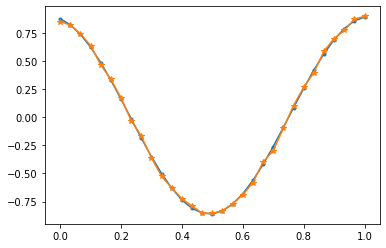

In [24]:
xMax = 1
response0 =  response[0] - np.mean( response[0] )
a0, b0, w0, phi0, Freq = fit_freq(drive_duration, response0, xMax)

fparm_List = [np.array([a0, b0, w0, phi0])]
Amp_List   = [drive_amps[0]]
w0_List     = [w0]
Freq_List   = [Freq]
xMax_List  = [xMax]

#  More schedules:  changing both Amplitude & durations

amp=0.35833333333333334, xMax_scale=1.1944444444444444
amp=0.41666666666666663, xMax_scale=1.3888888888888888
amp=0.475, xMax_scale=1.5833333333333333
amp=0.5333333333333333, xMax_scale=1.777777777777778
amp=0.5916666666666666, xMax_scale=1.9722222222222219


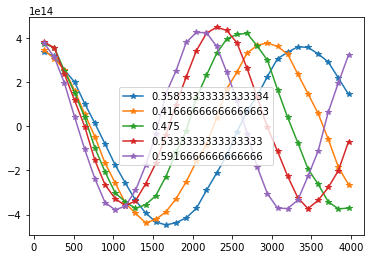

In [25]:
Look_AR = np.arange(1, 6)
#for cnt in np.arange(1, len(drive_amps)):
for cnt in Look_AR:
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp)
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))
    #print(resp_Amp)

    plt.plot(drive_duration,np.real(resp_Amp),'-*')
plt.legend(drive_amps[Look_AR])

amp=0.6499999999999999, xMax_scale=2.1666666666666665
amp=0.7083333333333333, xMax_scale=2.361111111111111
amp=0.7666666666666666, xMax_scale=2.5555555555555554
amp=0.825, xMax_scale=2.75
amp=0.8833333333333333, xMax_scale=2.9444444444444446
amp=0.9416666666666667, xMax_scale=3.138888888888889
amp=1.0, xMax_scale=3.3333333333333335


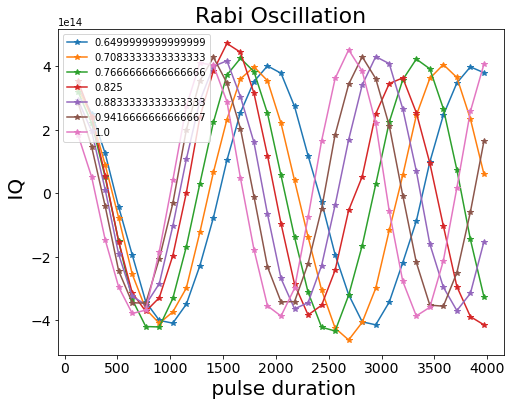

In [40]:
Look_AR = np.arange(6, len(drive_amps))
#for cnt in np.arange(1, len(drive_amps)):
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Rabi Oscillation', fontsize='22')
for cnt in Look_AR:
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp)
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))
    #print(resp_Amp)

    plt.plot(drive_duration,np.real(resp_Amp),'-*')
plt.legend(drive_amps[Look_AR])
plt.xlabel(' pulse duration', fontsize='20')
plt.ylabel(' IQ', fontsize='20')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.savefig('Oscillation.jpg', bbox_inches = 'tight', transparent = True, dpi=150)
plt.show()

In [27]:
#Generate the Rabi oscillation plot and find the 𝜋-pulse amplitude:

amp=0.35833333333333334, xMax_scale=1.19
 ***************** 
1.004800928857358 -0.11171063785012482 0.950055050488102 0.23373682002977056
0.03981481481481482 128 0.00031105324074074076 0.950055050488102 0.0002955177023364322
amp=0.41666666666666663, xMax_scale=1.39
 ***************** 
0.8841834420720501 -0.062010403558846856 0.9418523788223033 0.2640447704134145
0.04629629629629629 128 0.00036168981481481474 0.9418523788223033 0.0003406584124791316
amp=0.475, xMax_scale=1.58
 ***************** 
0.7541063181207939 0.03966545119472558 0.9379804496415755 0.30358809938983733
0.05277777777777778 128 0.0004123263888888889 0.9379804496415755 0.0003867540916490871
amp=0.5333333333333333, xMax_scale=1.78
 ***************** 
0.724362671117464 0.08048848003339039 0.9263624773894893 0.362237730482081
0.059259259259259255 128 0.0004629629629629629 0.9263624773894893 0.0004288715173099487
amp=0.5916666666666666, xMax_scale=1.97
 ***************** 
0.829631536646545 0.05054368973940656 0.923269667870

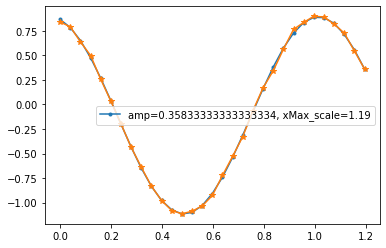

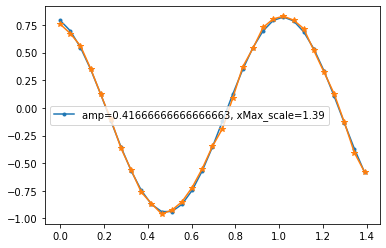

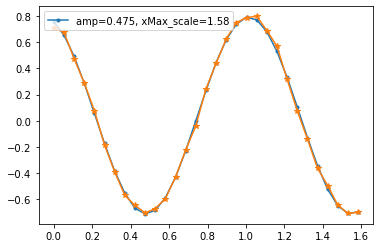

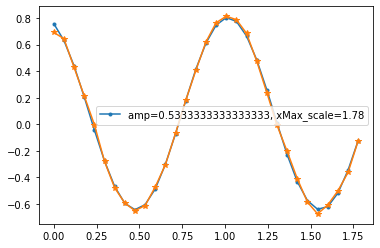

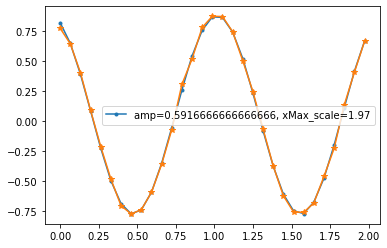

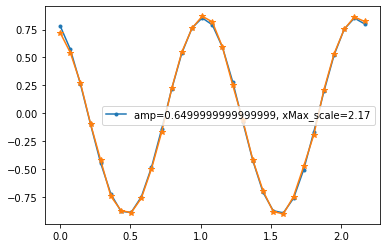

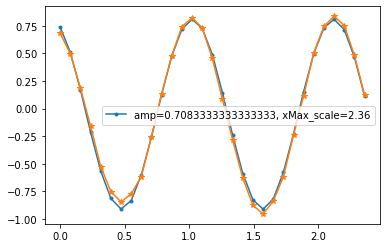

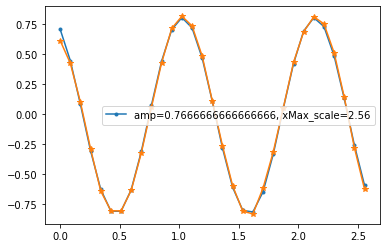

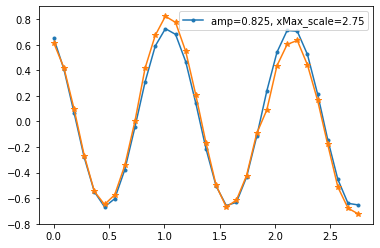

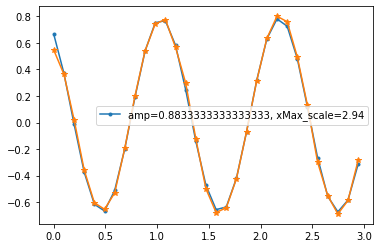

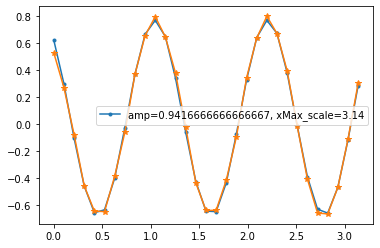

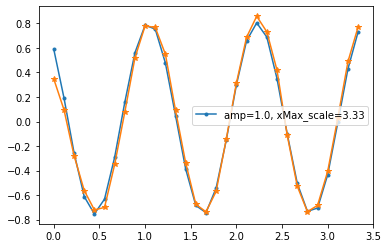

In [28]:
for cnt in np.arange(1, len(drive_amps)):
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp)
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax

    print('amp={}, xMax_scale={:.2f}'.format(amp, xMax_scal))

    a0, b0, w0, phi0, Freq = fit_freq(drive_duration, resp_Amp, xMax_scal)
    plt.legend(['amp={}, xMax_scale={:.2f}'.format(amp, xMax_scal)])


    Amp_List.append(amp)
    w0_List.append(w0)
    Freq_List.append(Freq)
    xMax_List.append(xMax_scal)
    fparm_List.append(np.array([a0, b0, w0, phi0]))

In [29]:
print(Amp_List)
print(w0_List)
print(Freq_List)
print(xMax_List)
print(fparm_List)

[0.3, 0.35833333333333334, 0.41666666666666663, 0.475, 0.5333333333333333, 0.5916666666666666, 0.6499999999999999, 0.7083333333333333, 0.7666666666666666, 0.825, 0.8833333333333333, 0.9416666666666667, 1.0]
[0.9495985601006225, 0.950055050488102, 0.9418523788223033, 0.9379804496415755, 0.9263624773894893, 0.9232696678701505, 0.9190274511270876, 0.9122492509344658, 0.8985881932835964, 0.8936740682945619, 0.8734457905703285, 0.8602507791507844, 0.8427644024050616]
[0.00024729129169287045, 0.0002955177023364322, 0.0003406584124791316, 0.0003867540916490871, 0.0004288715173099487, 0.00047419087397844814, 0.0005185484750283045, 0.0005609171464802487, 0.0005980187628912822, 0.0006400009603671991, 0.0006697428660333826, 0.000703185315712085, 0.0007315663215321716]
[1, 1.1944444444444444, 1.3888888888888886, 1.5833333333333333, 1.7777777777777777, 1.9722222222222217, 2.166666666666666, 2.3611111111111107, 2.555555555555555, 2.7499999999999996, 2.944444444444444, 3.138888888888889, 3.3333333333

In [30]:
IDsort = np.argsort(Amp_List);                  print(IDsort)
Amp_List = np.array(Amp_List)[IDsort];      print(Amp_List)
w0_List    = np.array(w0_List)[IDsort];               print(w0_List)
Freq_List  = np.array(Freq_List)[IDsort];             print(Freq_List)
xMax_List  = np.array(xMax_List)[IDsort];           print(xMax_List)
fparm_List = np.array(fparm_List)[IDsort,:];       print(fparm_List)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0.3        0.35833333 0.41666667 0.475      0.53333333 0.59166667
 0.65       0.70833333 0.76666667 0.825      0.88333333 0.94166667
 1.        ]
[0.94959856 0.95005505 0.94185238 0.93798045 0.92636248 0.92326967
 0.91902745 0.91224925 0.89858819 0.89367407 0.87344579 0.86025078
 0.8427644 ]
[0.00024729 0.00029552 0.00034066 0.00038675 0.00042887 0.00047419
 0.00051855 0.00056092 0.00059802 0.00064    0.00066974 0.00070319
 0.00073157]
[1.         1.19444444 1.38888889 1.58333333 1.77777778 1.97222222
 2.16666667 2.36111111 2.55555556 2.75       2.94444444 3.13888889
 3.33333333]
[[ 0.87721381  0.01675254  0.94959856  0.21377714]
 [ 1.00480093 -0.11171064  0.95005505  0.23373682]
 [ 0.88418344 -0.0620104   0.94185238  0.26404477]
 [ 0.75410632  0.03966545  0.93798045  0.3035881 ]
 [ 0.72436267  0.08048848  0.92636248  0.36223773]
 [ 0.82963154  0.05054369  0.92326967  0.38805046]
 [ 0.87702056 -0.02285046  0.91902745  0.40650692]
 [ 0.85972753 

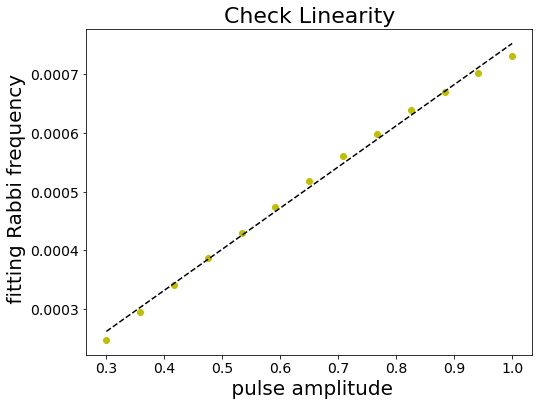

In [39]:
fit_coef   = np.polyfit(Amp_List, Freq_List, 1)
Rabi_linear  = np.poly1d(fit_coef)
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Check Linearity', fontsize='22')
plt.plot(Amp_List, Freq_List,'yo', Amp_List, Rabi_linear(Amp_List), '--k')
plt.xlabel(' pulse amplitude', fontsize='20')
plt.ylabel(' fitting Rabbi frequency', fontsize='20')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.savefig('linearity.jpg', bbox_inches = 'tight', transparent = True, dpi=150)
plt.show()